# Support Vector Classifier

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
df = pd.read_csv('../data/clinical_training_data.csv')

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['AD_dx_in_5_yrs'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["DX.bl"] = label_encoder.fit_transform(X["DX.bl"])
X["PTGENDER"] = label_encoder.fit_transform(X["PTGENDER"])
X["PTETHCAT"] = label_encoder.fit_transform(X["PTETHCAT"])
X["PTRACCAT"] = label_encoder.fit_transform(X["PTRACCAT"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate Model
svc = SVC()

### Grid Search

In [9]:
# Grid search
param_grid = {
    "C": [0.1, 1, 10],                
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 0.1],
    "degree": [1, 2, 3, 4, 5]}

In [10]:
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring="accuracy")

In [11]:
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [12]:
# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy: 0.8176688414741669


### Train with Best Parameters

In [13]:
# Instantiate and fit model
svc = SVC(C=1, degree=5, gamma="scale", kernel="poly")

svc.fit(X_resampled, y_resampled)

SVC(C=1, degree=5, kernel='poly')

In [14]:
# Assess
y_pred = svc.predict(X_test)

# evaluate predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81        79
           1       0.43      0.90      0.58        20

    accuracy                           0.74        99
   macro avg       0.70      0.80      0.69        99
weighted avg       0.86      0.74      0.76        99



# Neural Network

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE

tf.config.run_functions_eagerly(True)

In [24]:
df = pd.read_csv('../data/clinical_training_data.csv')

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['AD_dx_in_5_yrs'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["DX.bl"] = label_encoder.fit_transform(X["DX.bl"])
X["PTGENDER"] = label_encoder.fit_transform(X["PTGENDER"])
X["PTETHCAT"] = label_encoder.fit_transform(X["PTETHCAT"])
X["PTRACCAT"] = label_encoder.fit_transform(X["PTRACCAT"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [25]:
IN_FEATURES = X_train[0].shape[0]

In [26]:
def create_model(dropout=0.3, learning_rate=0.0001):
    
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(IN_FEATURES,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(512, activation="relu", name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(256, activation="relu", name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(2, activation="sigmoid", name="classification_layer")(hidden_2)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics="accuracy")
    
    return classification_model

In [27]:
model = create_model()

In [28]:
history = model.fit(X_resampled,
                    y_resampled,
                    batch_size=16,
                    epochs=20)

Epoch 1/20
 5/34 [===>..........................] - ETA: 0s - loss: 0.7055 - accuracy: 0.4375

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 [==============================] - 1s 28ms/step - loss: 0.6690 - accuracy: 0.6128
Epoch 2/20
34/34 [==============================] - 1s 28ms/step - loss: 0.6047 - accuracy: 0.7650
Epoch 3/20
34/34 [==============================] - 1s 28ms/step - loss: 0.5671 - accuracy: 0.7650
Epoch 4/20
34/34 [==============================] - 1s 28ms/step - loss: 0.5223 - accuracy: 0.7801
Epoch 5/20
34/34 [==============================] - 1s 28ms/step - loss: 0.4960 - accuracy: 0.7801
Epoch 6/20
34/34 [==============================] - 1s 28ms/step - loss: 0.4768 - accuracy: 0.7801
Epoch 7/20
34/34 [==============================] - 1s 28ms/step - loss: 0.4677 - accuracy: 0.7857
Epoch 8/20
34/34 [==============================] - 1s 28ms/step - loss: 0.4582 - accuracy: 0.7801
Epoch 9/20
34/34 [==============================] - 1s 29ms/step - loss: 0.4513 - accuracy: 0.7932
Epoch 10/20
34/34 [==============================] - 1s 29ms/step - loss: 0.4505 - accuracy: 0.7857
Epoch 11/20
34/34 [=

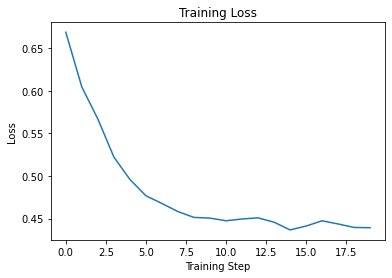

In [29]:
# Visualize loss curve

losses = history.history["loss"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [30]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 10ms/step - loss: 0.4891 - accuracy: 0.7374


[0.4891437292098999, 0.7373737096786499]

In [31]:
preds = model.predict(X_test)
preds

4/4 [==============================] - 0s 4ms/step


array([[0.77603734, 0.23016505],
       [0.49900967, 0.54025495],
       [0.4138175 , 0.6206088 ],
       [0.85008126, 0.15593433],
       [0.37386608, 0.66032463],
       [0.3645603 , 0.6602449 ],
       [0.5543312 , 0.47125974],
       [0.6066308 , 0.4270262 ],
       [0.8550956 , 0.1453831 ],
       [0.8171459 , 0.19049555],
       [0.50798565, 0.5166798 ],
       [0.47653708, 0.55115294],
       [0.5600483 , 0.4664184 ],
       [0.8487889 , 0.1475066 ],
       [0.4093537 , 0.62439656],
       [0.8251321 , 0.1680773 ],
       [0.39258134, 0.6512123 ],
       [0.89555824, 0.10634004],
       [0.5386116 , 0.49279517],
       [0.4937107 , 0.53507346],
       [0.51616716, 0.52222216],
       [0.8877597 , 0.11595295],
       [0.40444088, 0.6346134 ],
       [0.8115865 , 0.18836631],
       [0.89411294, 0.10666152],
       [0.8864143 , 0.11820167],
       [0.74569297, 0.2615231 ],
       [0.369167  , 0.67469823],
       [0.8948425 , 0.10672133],
       [0.8951156 , 0.10636437],
       [0.